### Import google drive and libraries


In [166]:
%matplotlib inline
from google.colab import drive
import pandas as pd
import datetime as dt
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### preprocessing function

In [0]:
def preprocess_dataset(dataset, ground_truth):

    #24 hour format string
    dataset['UTC_Time'] = pd.to_datetime(dataset['UTC_Time']).dt.strftime('%H:%M:%S')
    #change string to timedelta format for resampling
    dataset['UTC_Time'] = pd.to_timedelta(dataset['UTC_Time'], 's').dt.total_seconds()

    #calculate z-score and remove values with σ > 3
    dataset = dataset[(np.abs(stats.zscore(dataset.iloc[:,2:5])) < 3).all(axis=1)]

    #timedelta format for uptime
    dataset['UpTime'] = pd.to_timedelta(dataset['UpTime'], 'ms')

    #make uptime column df index for resampling
    dataset = dataset.set_index(dataset['UpTime'])

    #resample 50 ms
    dataset = dataset.resample('50ms').mean()
    dataset = dataset.fillna(method = 'ffill')

    #5 sec rolling window and keep median value
    dataset["Rolling_Value1"] = dataset['Value1'].rolling(100,min_periods=1).median()
    dataset["Rolling_Value2"] = dataset['Value2'].rolling(100,min_periods=1).median()
    dataset["Rolling_Value3"] = dataset['Value3'].rolling(100,min_periods=1).median()

    #calculate angle
    dataset['angle'] = np.arctan(dataset["Rolling_Value3"] / np.sqrt( np.square(dataset["Rolling_Value1"]) + np.square(dataset["Rolling_Value2"]))) * 180 / np.pi

    #create a new df(epoch_df) with utc_time angle and uptime as index
    epoch_df = dataset[['UTC_Time', 'angle']]
    
    #5 sec resample for epoch
    epoch_df = epoch_df.resample('5s').mean()

    #calculate angle differences
    epoch_df['angle change'] = epoch_df['angle'].diff().fillna(method = 'bfill')

    #create new columns for sleep_5 sleep_10 windows
    epoch_df['sleep_5'] = epoch_df['angle change']
    epoch_df['sleep_10'] = epoch_df['angle change']

    #new 5 min window and 10 min window

    #change sleep_5/sleep_10 to True/False
    epoch_df['sleep_5'] = epoch_df['sleep_5'].apply(lambda x: abs(x) < 5)
    epoch_df['sleep_10'] = epoch_df['sleep_10'].apply(lambda x: abs(x) < 5)

    #index arrays where angle change is bigger than 5     
    index_5 = epoch_df['sleep_5'][epoch_df['sleep_5']==False].index
    index_10 = epoch_df['sleep_10'][epoch_df['sleep_10']==False].index

    #change values between 2 5 degree angle changes to True if time is bigger than 300 seconds/600 seconds
    for i in range(index_5.shape[0] - 1):
        if (index_5[i+1] - index_5[i] > dt.timedelta(seconds = 300)):
            epoch_df['sleep_5'].loc[index_5[i]+dt.timedelta(seconds = 5):index_5[i+1]-dt.timedelta(seconds = 5)] = True
        else:
            epoch_df['sleep_5'].loc[index_5[i]+dt.timedelta(seconds = 5):index_5[i+1]-dt.timedelta(seconds = 5)] = False
            

    for i in range(index_10.shape[0] - 1):
        if (index_10[i+1] - index_10[i] > dt.timedelta(seconds = 600)):
            epoch_df['sleep_10'].loc[index_10[i]+dt.timedelta(seconds = 5):index_10[i+1]-dt.timedelta(seconds = 5)] = True
        else:
            epoch_df['sleep_10'].loc[index_10[i]+dt.timedelta(seconds = 5):index_10[i+1]-dt.timedelta(seconds = 5)] = False


    #groupby every 5 min/10min and set max value to sleep column
    #epoch_df['sleep_5'] = epoch_df.groupby(pd.Grouper(freq = '5min') )['sleep_5'].transform('max')
    #epoch_df['sleep_10'] = epoch_df.groupby(pd.Grouper(freq = '10min') )['sleep_10'].transform('max')

    #if angle difference < 5 return True
    #epoch_df['sleep_5'] = epoch_df['sleep_5'].apply(lambda x: abs(x) < 5)
    #epoch_df['sleep_10'] = epoch_df['sleep_10'].apply(lambda x: abs(x) < 5)

    #fix UTC_time to H:M:S format
    #turn seconds to H:M:S string
    epoch_df['UTC_Time'] = epoch_df['UTC_Time'].apply(lambda x: str(dt.timedelta(seconds = int(x))))
    #turn string to datetime object
    epoch_df['UTC_Time'] = pd.to_datetime(epoch_df['UTC_Time']).dt.strftime('%H:%M:%S')
    epoch_df['UTC_Time'] = pd.to_datetime(epoch_df['UTC_Time'],format= '%H:%M:%S' ).dt.time

    #change index to UTC time
    epoch_df = epoch_df.set_index(epoch_df['UTC_Time'])

    #create ground truth column
    d = lambda x: 90 if (x > ground_truth[1] and x < ground_truth[2]) else np.NaN
    epoch_df['ground truth'] = epoch_df['UTC_Time'].apply(d)

    #formatting to help with plotting
    epoch_df['sleep_5']  = epoch_df['sleep_5'].apply(lambda x: 100 if x == True else  np.NaN)
    epoch_df['sleep_10']  = epoch_df['sleep_10'].apply(lambda x: 110 if x == True else np.NaN)
    #epoch_df = epoch_df.drop(['angle'], axis = 1)

    return epoch_df



### print results function

In [0]:
def print_results(cleaned_df):
    #fill NaN values with 0 and calculate differences so we can detect changes in sleep
    results_5 = cleaned_df['sleep_5'].fillna(0)[cleaned_df['sleep_5'].fillna(0).diff() != 0.0].astype(bool)
    results_10 = cleaned_df['sleep_10'].fillna(0)[cleaned_df['sleep_10'].fillna(0).diff() != 0.0].astype(bool)
    results_gt = cleaned_df['ground truth'].fillna(0)[cleaned_df['ground truth'].fillna(0).diff() != 0.0].astype(bool)

    #create lists with sleep intervals
    result5_list = []
    for i in range(results_5.shape[0] - 1):
        result5_list.append(["{} - {}".format(str(results_5.index[i]), str(results_5.index[i+1])), results_5[i]])

    result10_list = []
    for i in range(results_10.shape[0] - 1):
        result10_list.append(["{} - {}".format(str(results_10.index[i]), str(results_10.index[i+1])), results_10[i]])

    resultgt_list = []
    for i in range(results_gt.shape[0] - 1):
        resultgt_list.append(["{} - {}".format(str(results_gt.index[i]), str(results_gt.index[i+1])), results_gt[i]])

    #create dataframes with lists
    results5_df  = pd.DataFrame(result5_list)
    results10_df  = pd.DataFrame(result10_list)
    resultsgt_df  = pd.DataFrame(resultgt_list)

    results5_df.columns = ['Time', 'Sleep']
    results10_df.columns = ['Time', 'Sleep']
    resultsgt_df.columns = ['Time', 'Sleep']

    #get results for rows that sleep = True
    results5_df  = results5_df[results5_df['Sleep'] == True]['Time']
    results10_df  = results10_df[results10_df['Sleep'] == True]['Time']
    resultsgt_df  = resultsgt_df[resultsgt_df['Sleep'] == True]['Time']

    #join dataframes in one
    res = pd.concat([results5_df,results10_df, resultsgt_df], ignore_index=True, axis=1)
    res.columns = ['παράθυρο 5 λεπτών', 'παράθυρο 10 λεπτών', 'ground truth']
    res = res.fillna('-').reset_index(drop= True)
    res.index.name = 'Διαστήματα ύπνου'
    return res

### load data and ground truth


In [169]:
path = '/content/drive/My Drive/ntelopoulos/'
dataset1 = pd.read_csv(path + 'AccelerometerData_101_30_05_19.txt')
dataset2 = pd.read_csv(path + 'AccelerometerData_101_31_05_19.txt')
dataset3 = pd.read_csv(path + 'AccelerometerData_102_02_06_19.txt')
dataset4 = pd.read_csv(path + 'AccelerometerData_102_03_06_19.txt')
dataset5 = pd.read_csv(path + 'AccelerometerData_103_04_06_19.txt')
dataset6 = pd.read_csv(path + 'AccelerometerData_103_05_06_19.txt')


# sleep log had an error in the 3d line 12:24 instead of 00:24
ground_truth = pd.read_excel(path + 'SleepLog.xlsx')

ground_truth = ground_truth.transpose()
gt = pd.DataFrame(ground_truth.iloc[1:,:].reset_index(drop=True))
gt

,0,1,2,3,4,5
0,02:20:00,02:09:00,02:19:00,00:24:00,01:09:00,03:08:00
1,02:35:00,02:24:00,02:35:00,00:46:00,01:24:00,03:23:00
2,07:40:00,07:31:00,04:52:00,04:19:00,09:10:00,09:03:00
3,07:55:00,07:46:00,05:08:00,04:36:00,09:24:00,09:18:00


### Dataset 1 

In [170]:
cleaned_df = preprocess_dataset(dataset1, gt[0])
print_results(cleaned_df)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,παράθυρο 5 λεπτών,παράθυρο 10 λεπτών,ground truth
Διαστήματα ύπνου,,,
0,02:37:41 - 02:48:01,02:37:41 - 02:48:01,02:35:01 - 07:40:01
1,02:48:16 - 02:56:41,03:19:46 - 04:23:26,-
2,02:56:51 - 03:04:16,04:31:01 - 04:46:11,-
3,03:04:26 - 03:11:56,04:50:36 - 05:20:21,-
4,03:12:46 - 03:19:41,05:20:26 - 05:35:06,-
5,03:19:46 - 04:23:26,05:50:51 - 06:07:56,-
6,04:25:26 - 04:30:51,06:16:31 - 06:31:46,-
7,04:31:01 - 04:46:11,06:31:50 - 06:52:16,-
8,04:50:36 - 05:20:21,06:52:56 - 07:12:51,-


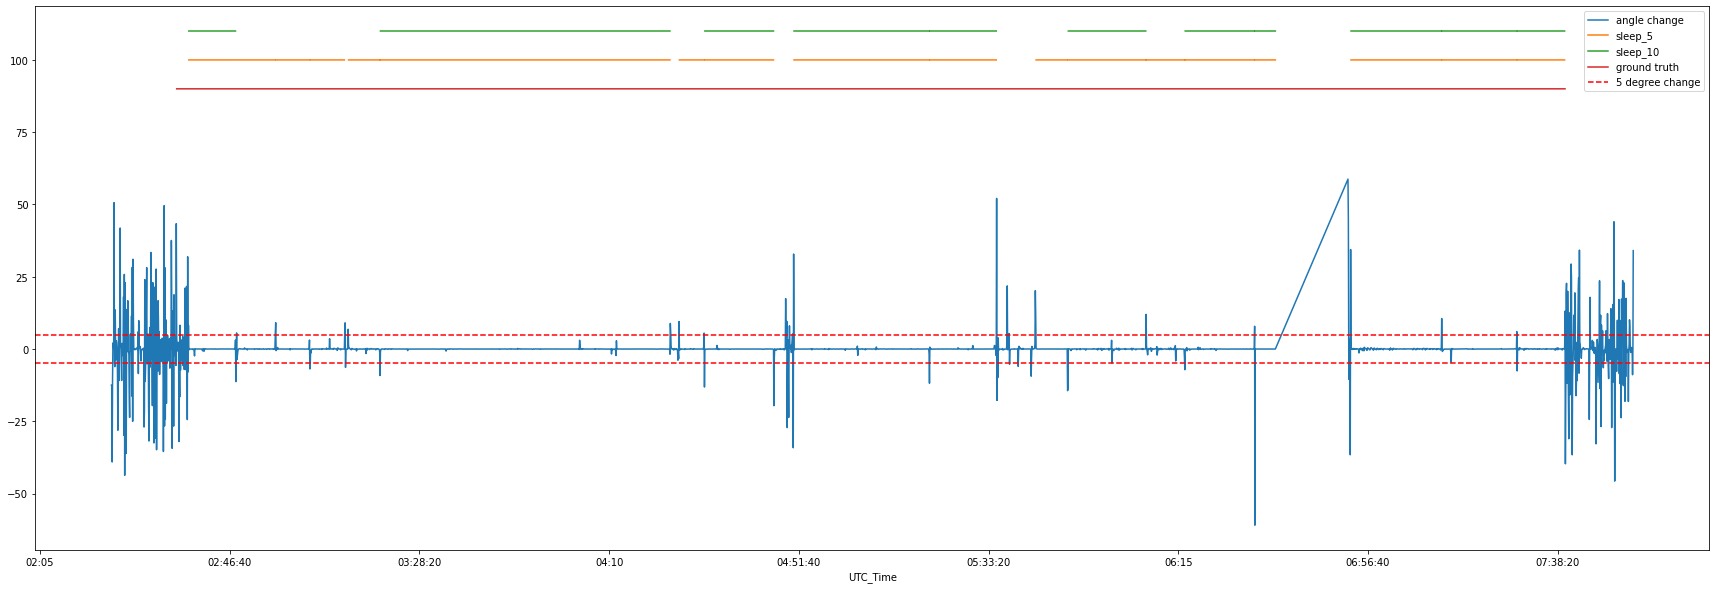

In [171]:
ax = cleaned_df.drop(['angle'], axis = 1).plot(figsize = (30,10))
ax.axhline(5, linestyle='--', color='r', label='5 degree change')
ax.axhline(-5, linestyle='--', color='r')
ax.legend()

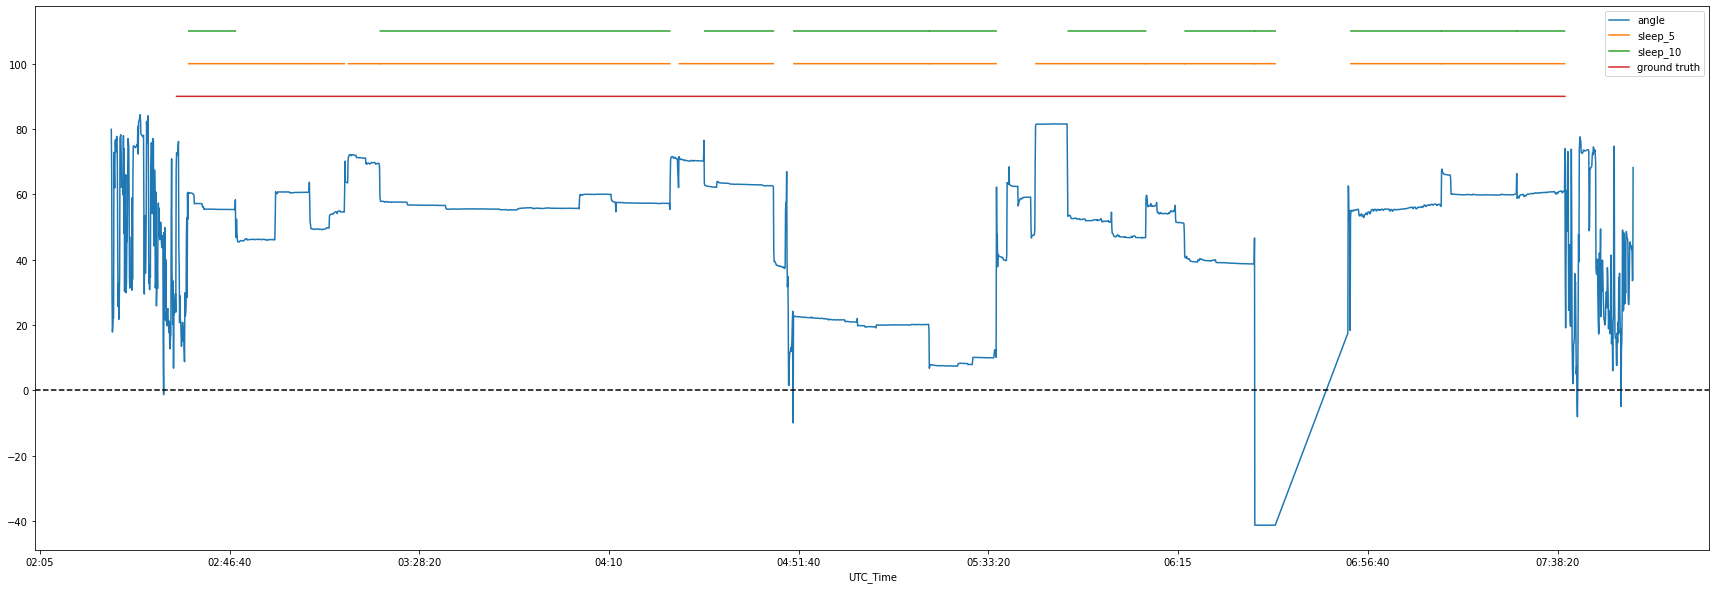

In [172]:
ax = cleaned_df.drop(['angle change'], axis = 1).plot(figsize = (30,10))
ax.axhline(0, linestyle='--', color='black')
ax.legend()

### Dataset 2 

In [173]:
cleaned_df2 = preprocess_dataset(dataset2, gt[1])
print_results(cleaned_df2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,παράθυρο 5 λεπτών,παράθυρο 10 λεπτών,ground truth
Διαστήματα ύπνου,,,
0,02:28:12 - 03:05:27,02:28:12 - 03:05:27,02:24:02 - 07:31:02
1,03:05:32 - 03:36:17,03:05:32 - 03:36:17,-
2,03:37:57 - 03:54:57,03:37:57 - 03:54:57,-
3,04:00:52 - 04:07:37,04:17:27 - 04:36:06,-
4,04:07:47 - 04:13:37,04:46:07 - 05:06:11,-
5,04:17:27 - 04:36:06,05:09:07 - 05:52:32,-
6,04:40:57 - 04:46:02,06:02:47 - 06:34:47,-
7,04:46:07 - 05:06:11,06:54:27 - 07:07:07,-
8,05:09:07 - 05:52:32,-,-


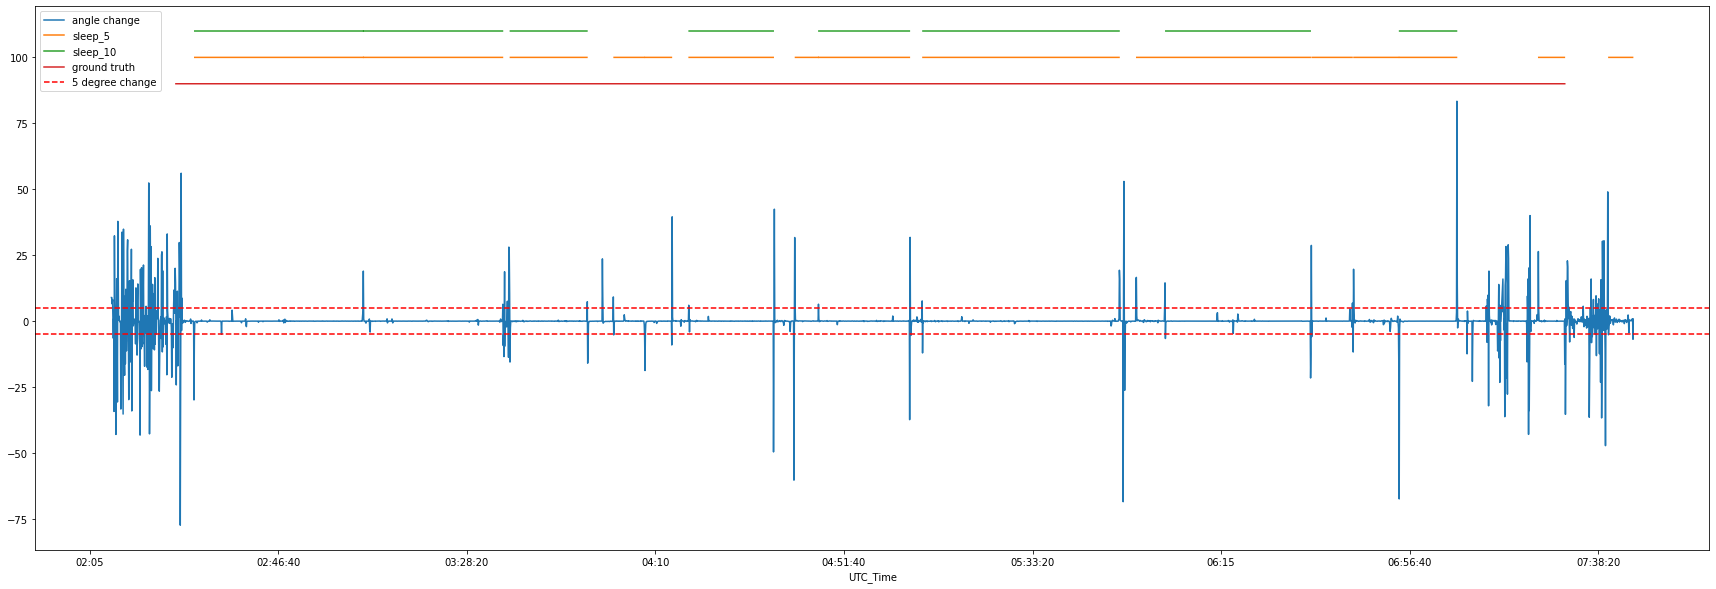

In [174]:
ax = cleaned_df2.drop(['angle'], axis = 1).plot(figsize = (30,10))
ax.axhline(5, linestyle='--', color='r', label='5 degree change')
ax.axhline(-5, linestyle='--', color='r')
ax.legend()

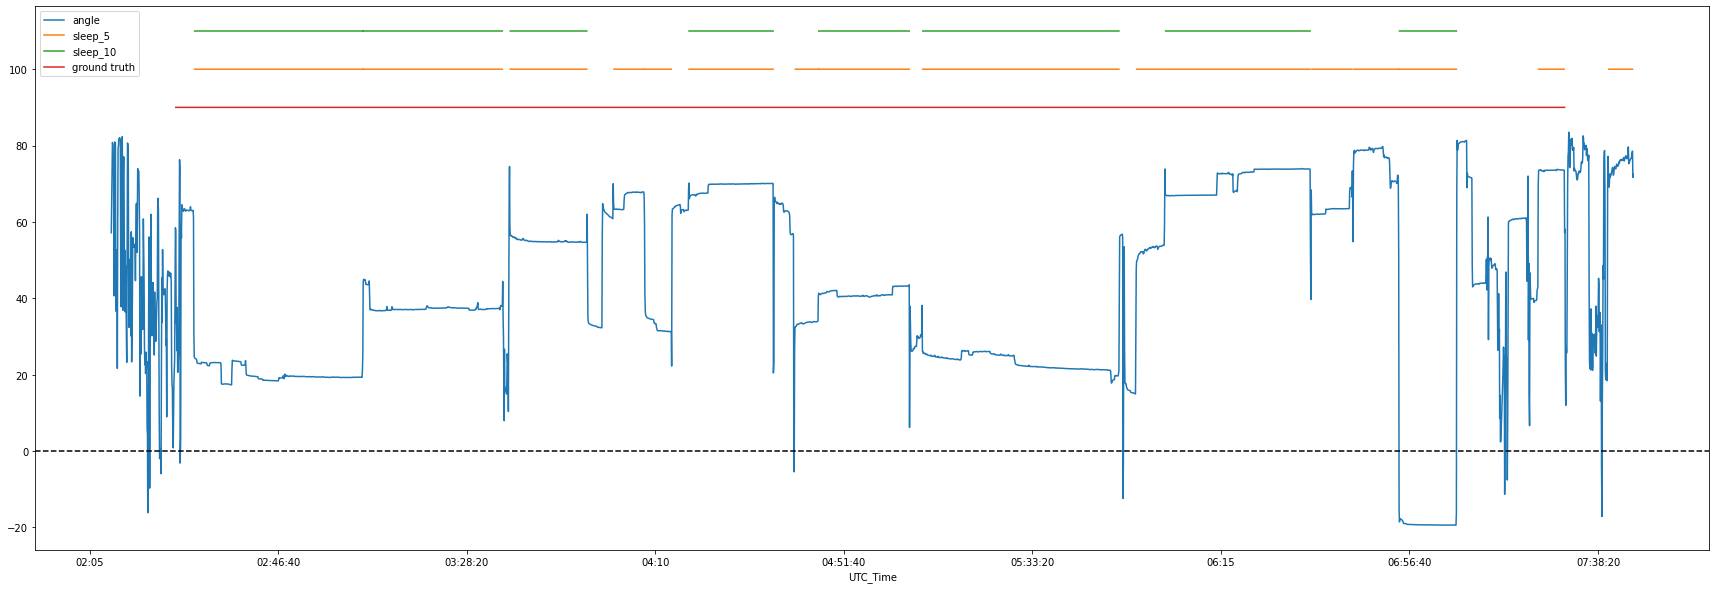

In [175]:
ax = cleaned_df2.drop(['angle change'], axis = 1).plot(figsize = (30,10))
ax.axhline(0, linestyle='--', color='black')
ax.legend()

### Dataset 3

In [176]:
cleaned_df3 = preprocess_dataset(dataset3, gt[2])
print_results(cleaned_df3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,παράθυρο 5 λεπτών,παράθυρο 10 λεπτών,ground truth
Διαστήματα ύπνου,,,
0,02:19:33 - 02:20:08,02:19:33 - 02:20:08,-
1,-,-,02:35:03 - 04:52:03
2,02:24:43 - 02:29:49,02:46:23 - 03:16:13,-
3,02:36:53 - 02:46:08,03:16:18 - 04:27:48,-
4,02:46:23 - 03:16:13,04:28:08 - 04:49:33,-
5,03:16:18 - 04:27:48,-,-
6,04:28:08 - 04:49:33,-,-


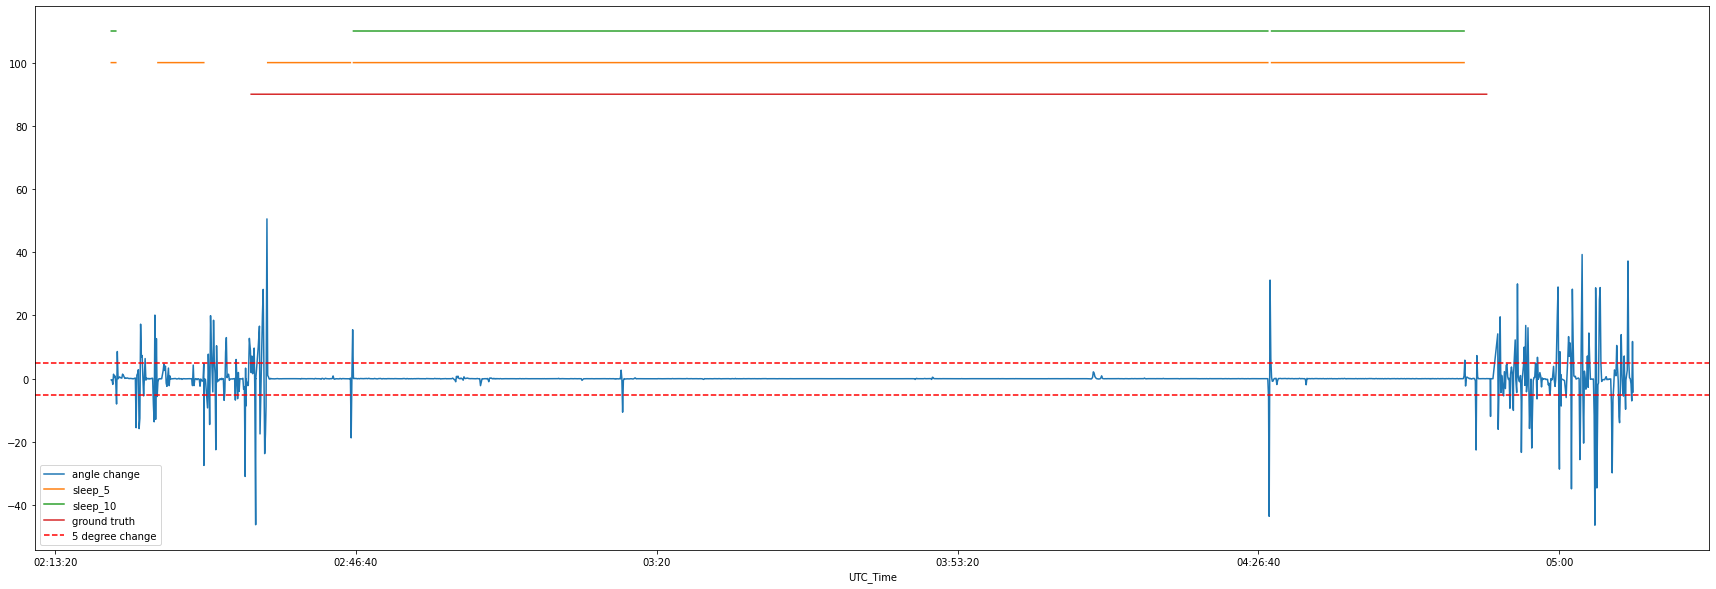

In [177]:
ax = cleaned_df3.drop(['angle'], axis = 1).plot(figsize = (30,10))
ax.axhline(5, linestyle='--', color='r', label='5 degree change')
ax.axhline(-5, linestyle='--', color='r')
ax.legend()

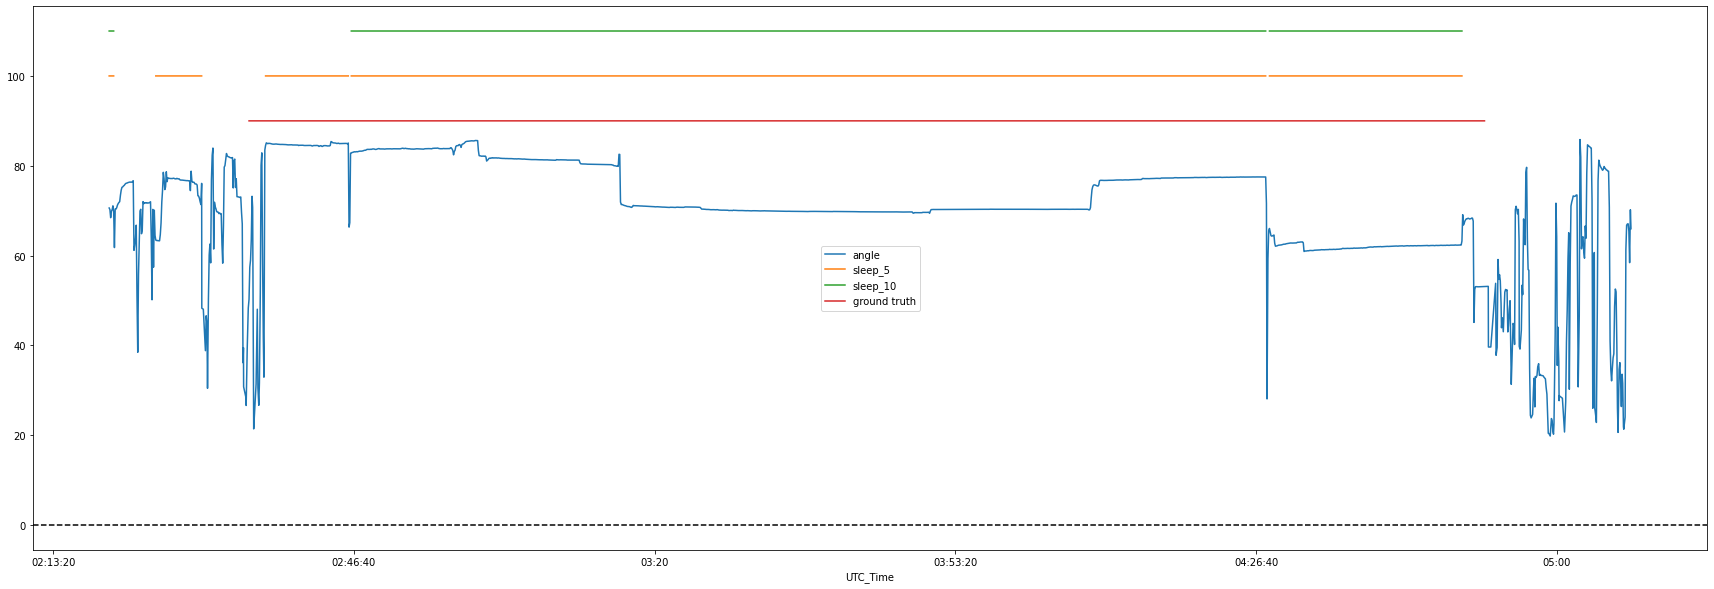

In [178]:
ax = cleaned_df3.drop(['angle change'], axis = 1).plot(figsize = (30,10))
ax.axhline(0, linestyle='--', color='black')
ax.legend()

### Dataset 4

In [179]:
cleaned_df4 = preprocess_dataset(dataset4, gt[3])
print_results(cleaned_df4)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,παράθυρο 5 λεπτών,παράθυρο 10 λεπτών,ground truth
Διαστήματα ύπνου,,,
0,00:24:09 - 00:24:19,00:24:09 - 00:24:19,-
1,-,-,00:46:04 - 04:19:04
2,00:47:14 - 00:53:14,00:53:19 - 01:19:49,-
3,00:53:19 - 01:19:49,01:36:19 - 01:51:19,-
4,01:26:19 - 01:36:09,02:10:04 - 02:23:54,-
5,01:36:19 - 01:51:19,02:24:24 - 03:35:49,-
6,01:51:34 - 01:59:39,03:36:04 - 04:10:14,-
7,02:10:04 - 02:23:54,-,-
8,02:24:24 - 03:35:49,-,-


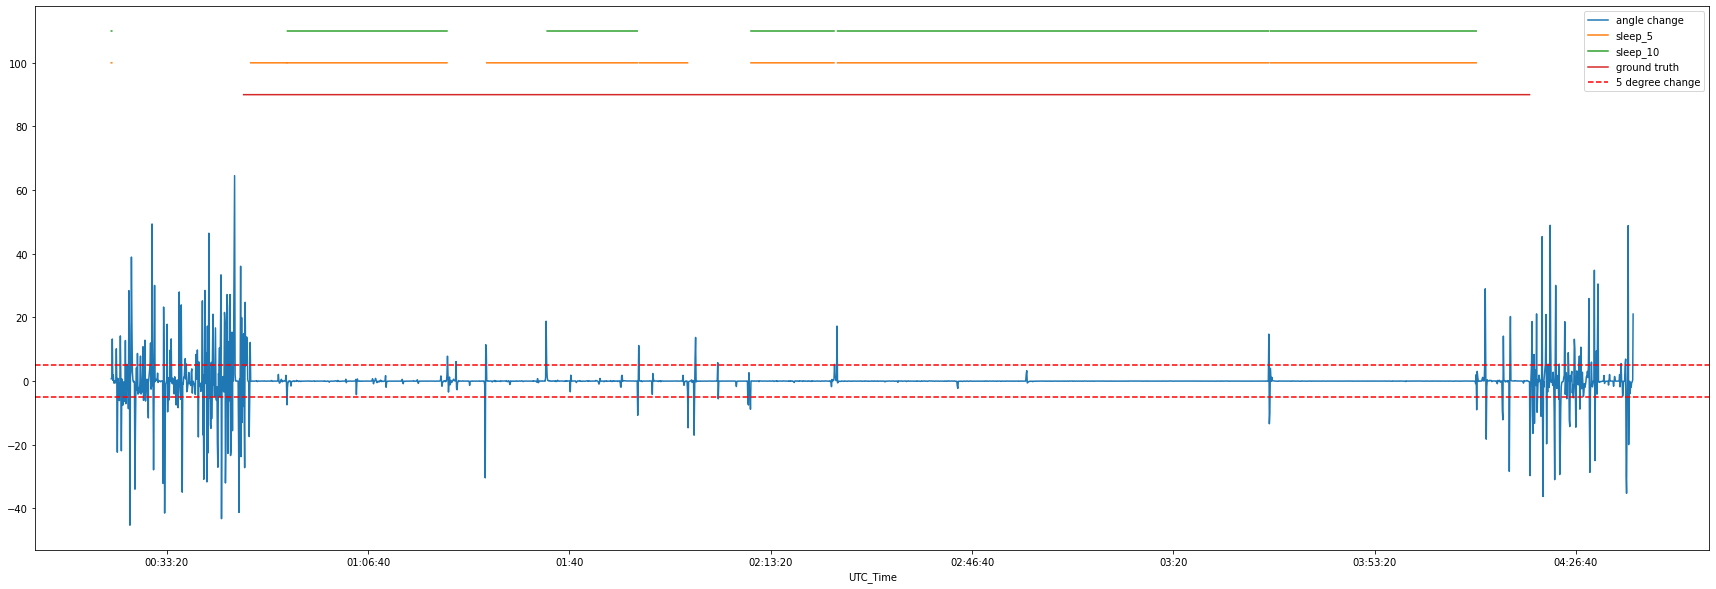

In [180]:
ax = cleaned_df4.drop(['angle'], axis = 1).plot(figsize = (30,10))
ax.axhline(5, linestyle='--', color='r', label='5 degree change')
ax.axhline(-5, linestyle='--', color='r')
ax.legend()

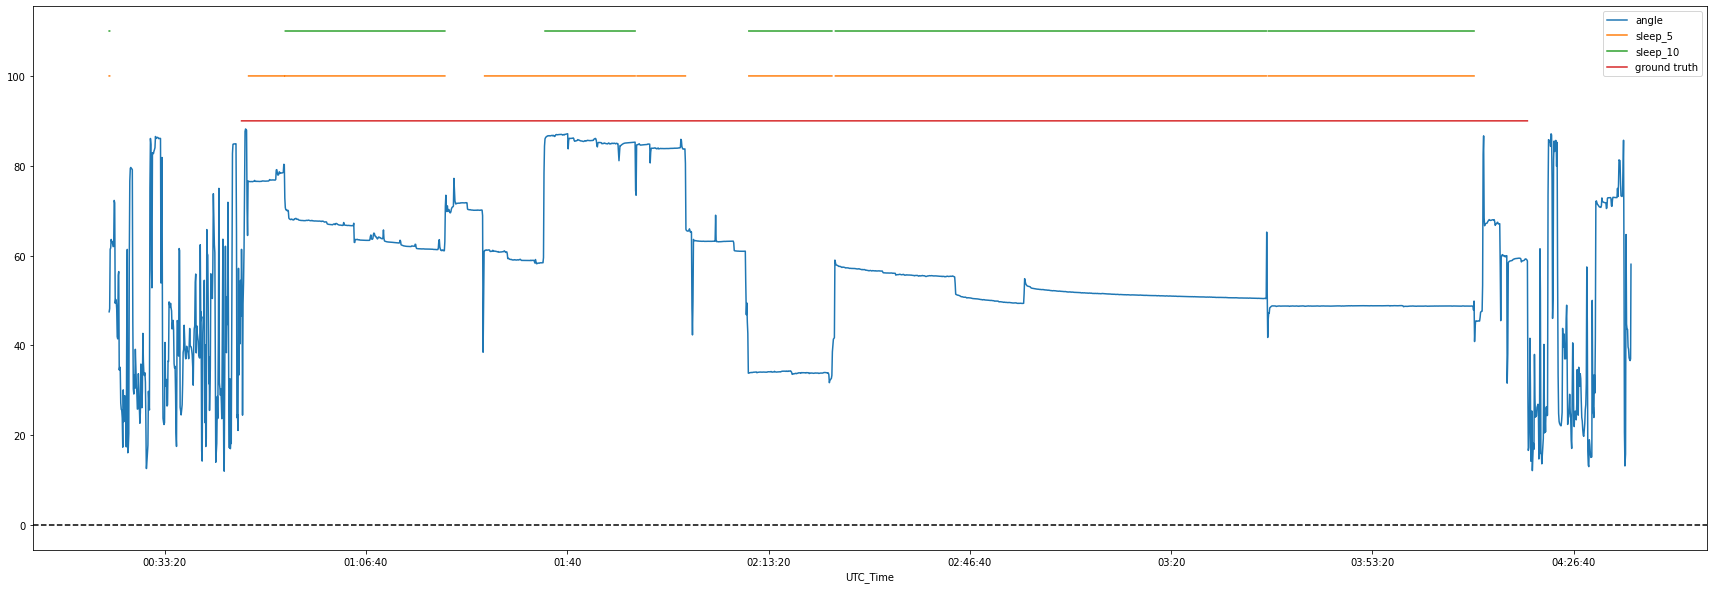

In [181]:
ax = cleaned_df4.drop(['angle change'], axis = 1).plot(figsize = (30,10))
ax.axhline(0, linestyle='--', color='black')
ax.legend()

### Dataset 5

In [182]:
cleaned_df5 = preprocess_dataset(dataset5, gt[4])
print_results(cleaned_df5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,παράθυρο 5 λεπτών,παράθυρο 10 λεπτών,ground truth
Διαστήματα ύπνου,,,
0,01:16:50 - 01:25:45,01:25:50 - 01:53:15,01:24:05 - 09:10:00
1,01:25:50 - 01:53:15,01:53:25 - 02:11:05,-
2,01:53:25 - 02:11:05,02:11:25 - 02:21:50,-
3,02:11:25 - 02:21:50,02:25:45 - 03:08:05,-
4,02:25:45 - 03:08:05,03:08:25 - 03:36:05,-
5,03:08:25 - 03:36:05,03:36:40 - 03:53:15,-
6,03:36:40 - 03:53:15,03:53:40 - 04:04:10,-
7,03:53:40 - 04:04:10,04:04:25 - 04:17:55,-
8,04:04:25 - 04:17:55,04:35:40 - 04:45:55,-


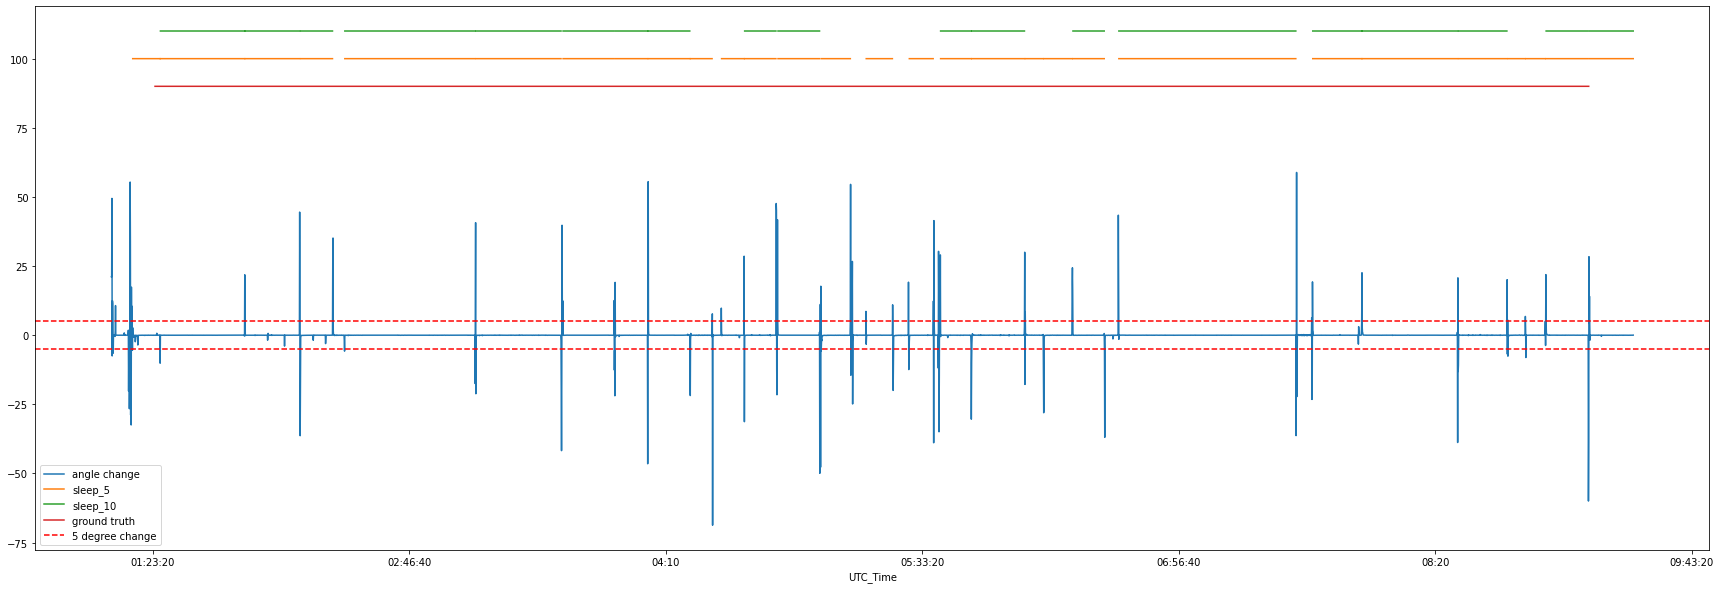

In [183]:
ax = cleaned_df5.drop(['angle'], axis = 1).plot(figsize = (30,10))
ax.axhline(5, linestyle='--', color='r', label='5 degree change')
ax.axhline(-5, linestyle='--', color='r')
ax.legend()

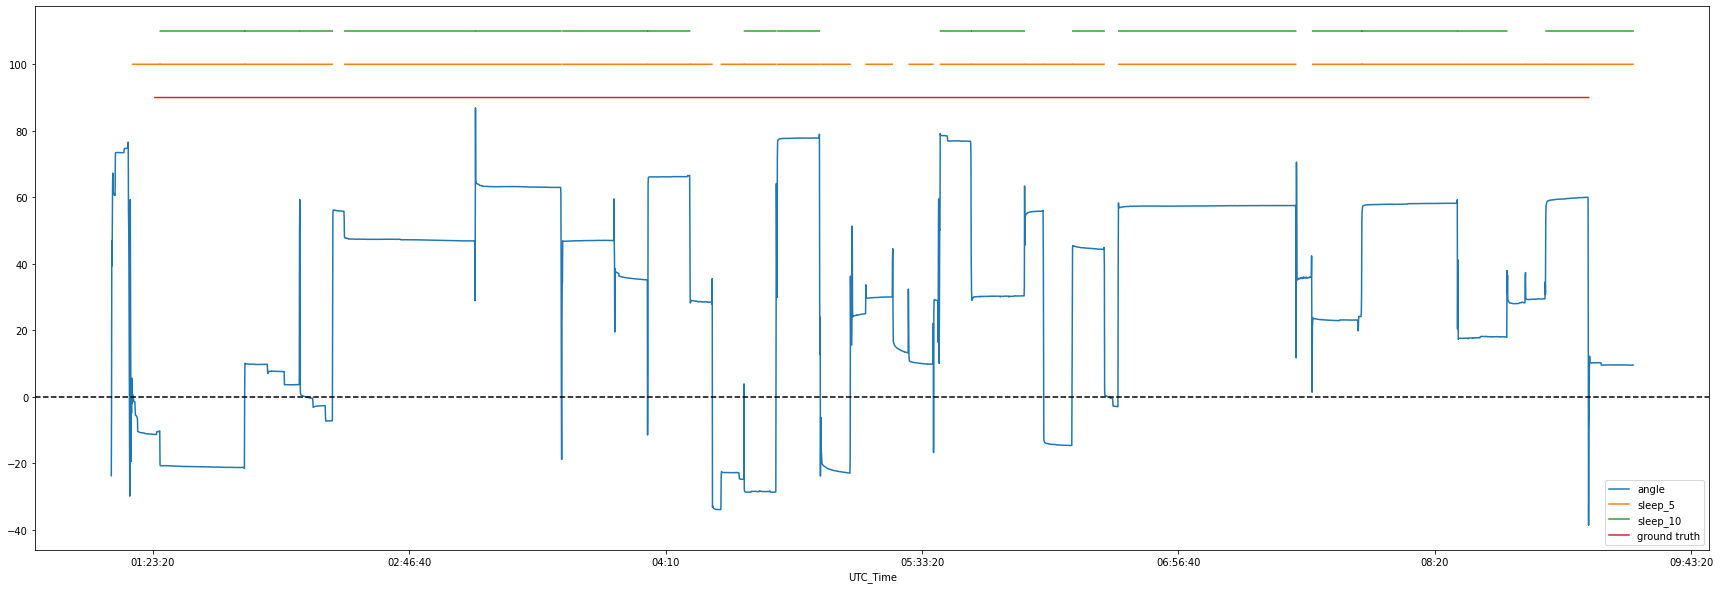

In [184]:
ax = cleaned_df5.drop(['angle change'], axis = 1).plot(figsize = (30,10))
ax.axhline(0, linestyle='--', color='black')
ax.legend()

### Dataset 6


In [185]:
cleaned_df6 = preprocess_dataset(dataset6, gt[5])
print_results(cleaned_df6)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,παράθυρο 5 λεπτών,παράθυρο 10 λεπτών,ground truth
Διαστήματα ύπνου,,,
0,03:14:48 - 03:21:38,03:27:58 - 04:09:28,03:23:03 - 09:03:03
1,03:27:58 - 04:09:28,04:09:58 - 04:22:23,-
2,04:09:58 - 04:22:23,04:28:03 - 05:10:23,-
3,04:22:28 - 04:27:43,05:14:08 - 05:34:33,-
4,04:28:03 - 05:10:23,05:34:43 - 05:45:48,-
5,05:14:08 - 05:34:33,05:46:03 - 06:15:28,-
6,05:34:43 - 05:45:48,06:27:03 - 06:41:18,-
7,05:46:03 - 06:15:28,06:48:53 - 07:03:38,-
8,06:16:38 - 06:26:13,07:09:58 - 07:20:38,-


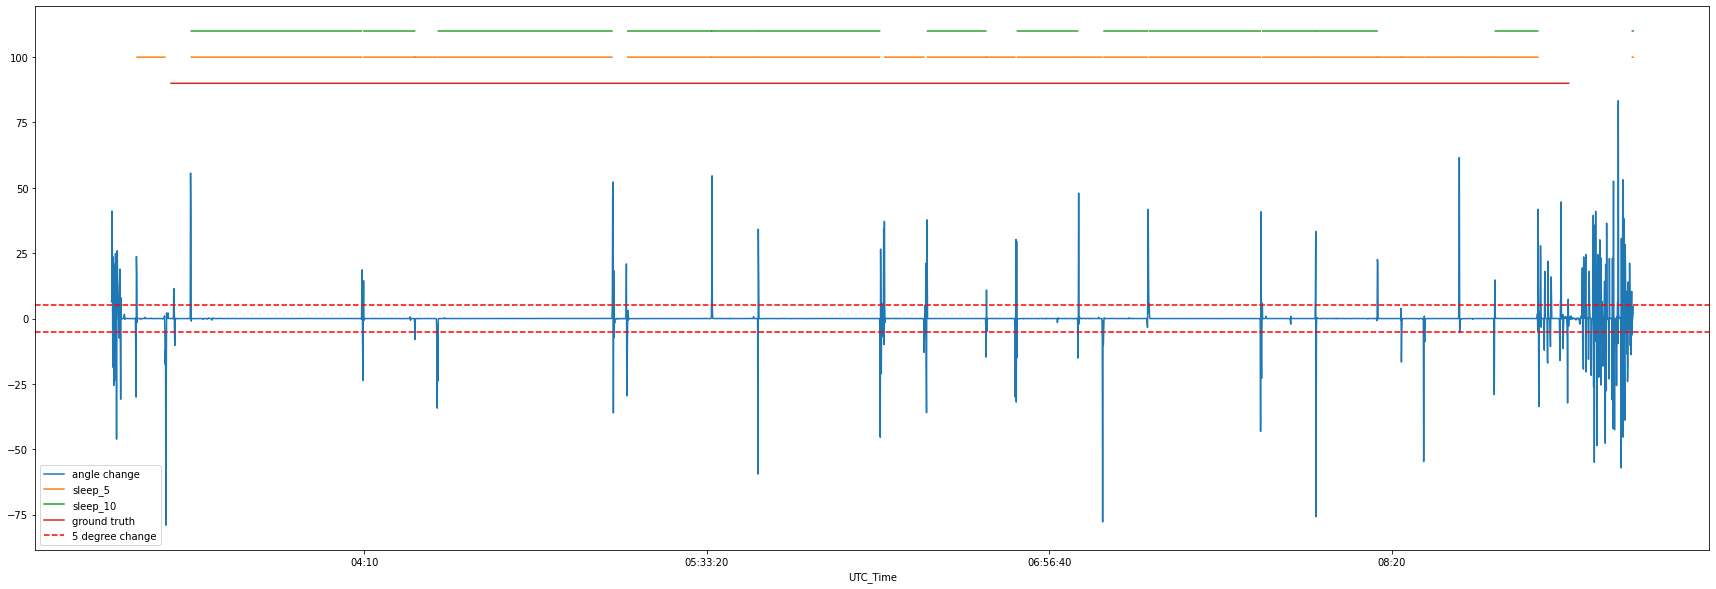

In [186]:
ax = cleaned_df6.drop(['angle'], axis = 1).plot(figsize = (30,10))
ax.axhline(5, linestyle='--', color='r', label='5 degree change')
ax.axhline(-5, linestyle='--', color='r')
ax.legend()

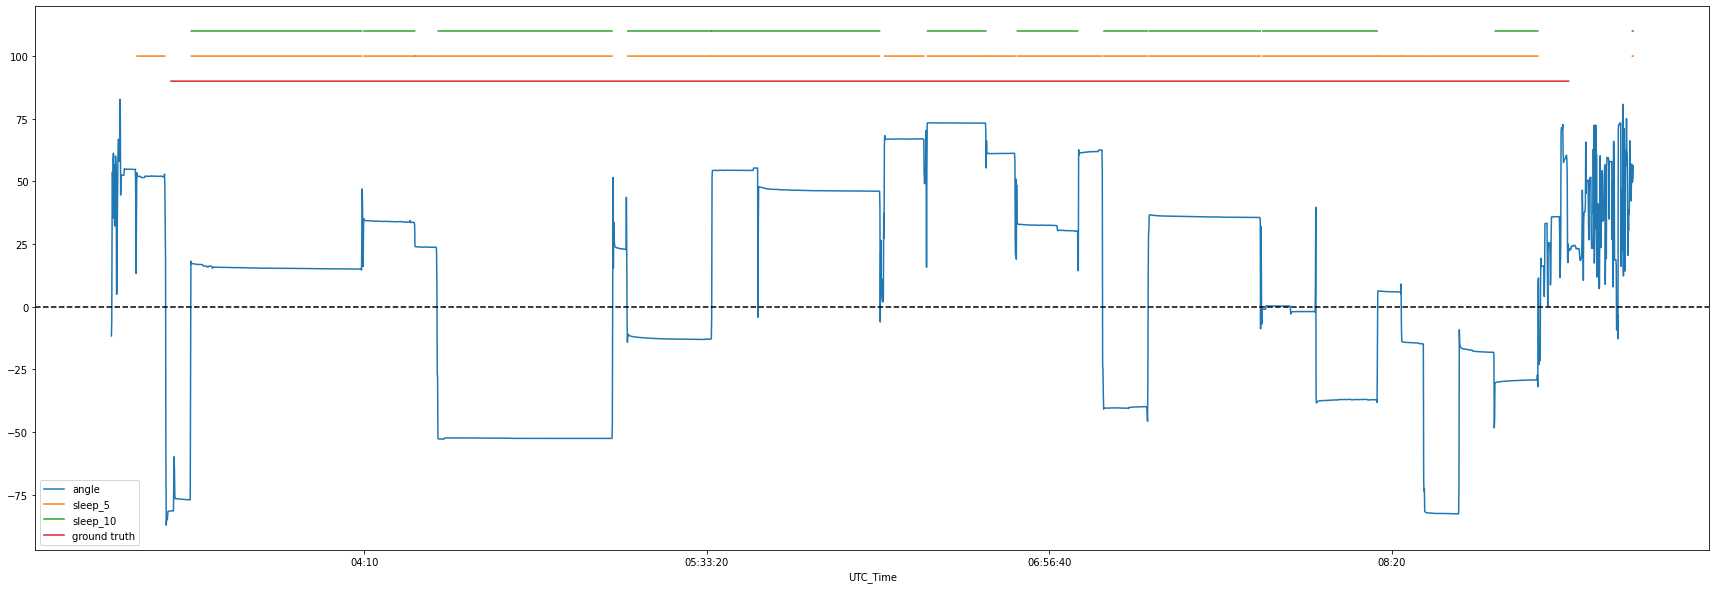

In [187]:
ax = cleaned_df6.drop(['angle change'], axis = 1).plot(figsize = (30,10))
ax.axhline(0, linestyle='--', color='black')
ax.legend()

# MAPE

In [188]:
##σωστό???? αυθαίρετα πήρα τιμές 1 και 2 για τιμές ύπνου/ξύπνιου για να μην υπάρχουν διαιρέσεις με το μηδέν
MAPE1 = cleaned_df6.fillna(0)
MAPE1['sleep_5'] = MAPE1['sleep_5'].apply(lambda x: 1 if x == 0 else 2)
MAPE1['sleep_10'] = MAPE1['sleep_10'].apply(lambda x: 1 if x == 0 else 2)
MAPE1['ground truth'] = MAPE1['ground truth'].apply(lambda x: 1 if x == 0 else 2)

error10 = ((MAPE1['ground truth']-MAPE1['sleep_10'])/MAPE1['ground truth']).abs().sum()/MAPE1.shape[0]
error5 = ((MAPE1['ground truth']-MAPE1['sleep_5'])/MAPE1['ground truth']).abs().sum()/MAPE1.shape[0]
error5

0.05064145847400405

In [0]:
#error calculate function

def error_calculation(df):
    MAE = df.fillna(0)
    MAE['sleep_5'] = MAE['sleep_5'].apply(lambda x: 0 if x == 0 else 1)
    MAE['sleep_10'] = MAE['sleep_10'].apply(lambda x: 0 if x == 0 else 1)
    MAE['ground truth'] = MAE['ground truth'].apply(lambda x: 0 if x == 0 else 1)

    error10 = ((MAE['ground truth']-MAE['sleep_10'])).abs().sum()/MAE.shape[0]
    error5 = ((MAE['ground truth']-MAE['sleep_5'])).abs().sum()/MAE.shape[0]

    return error5, error10

In [190]:
error1_5, error1_10 = error_calculation(pd.concat([cleaned_df,cleaned_df2]))
error2_5, error2_10 = error_calculation(pd.concat([cleaned_df3,cleaned_df4]))
error3_5, error3_10 = error_calculation(pd.concat([cleaned_df5,cleaned_df6]))

frames = [cleaned_df, cleaned_df2 ,cleaned_df3 ,cleaned_df4,cleaned_df5 ,cleaned_df6]
total_df = pd.concat(frames)

error_5_total,  error_10_total  =  error_calculation(total_df)

mae_results = pd.DataFrame([['Participant_1',error1_5, error1_10],['Participant_2',error2_5, error2_10],['Participant_3',error3_5, error3_10],
                           ['total', error_5_total, error_10_total]])
mae_results.columns = ['Participants','5min window error', '10min window error']
mae_results

,Participants,5min window error,10min window error
0,Participant_1,0.109206,0.249472
1,Participant_2,0.093069,0.159604
2,Participant_3,0.101272,0.227982
3,total,0.102228,0.220641
